# Reflection Agents
Inspiration: https://blog.langchain.dev/reflection-agents/

Reflection Agents consists of two basic components:

1. A **generator**, which is really any agent able to accomplish a task, with or without tools.
2. A **reflector**, which offers criticism and feedback to the generator to have it re-try with advice.

In [ ]:
import os

# Set up API keys
os.environ["OPENAI_API_KEY"] = ""

## A simple Agent - Writing Linkedin Posts

In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You write engaging Linkedin Posts."
        ),
        MessagesPlaceholder(variable_name="messages"), #MessagesPlaceholder is a class/object recognized by LangChain's chat prompt system, enabling dynamic and flexible message history injection.
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini")

generate = prompt | llm

In [3]:
request = "Write one about me completing day one of filming my AI agent course"
first_draft_response = generate.invoke({"messages": [("user", request)]})

In [4]:
print(first_draft_response.content)

🎬 Exciting Milestone Alert! 🌟

Today marks the completion of DAY ONE of filming my AI Agent Course! 🚀 It’s been a whirlwind of creativity, learning, and collaboration. I’m thrilled to be diving into the fascinating world of AI and sharing these insights with you all.

From brainstorming concepts to setting up the perfect shot, every moment has been a reminder of why I love what I do. This course is all about empowering you to harness the power of AI and turn it into a valuable asset for your projects, businesses, or personal growth.

I can't wait to share the knowledge and tools I’ve gathered along the way. Here’s to the journey of bringing ideas to life, one frame at a time!

Stay tuned for more updates as I continue this adventure! 🚀🎥 #AI #Filming #LearningJourney #Innovation #StayTuned


## Reflecting on our agent's work

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a marketing strategist looking over social media posts. Generate critique and recommendations for the user's post."
            " Provide detailed recommendations on things including length, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [7]:
reflection = reflect.invoke({"messages": [("user", request), ("user", first_draft_response.content)]})

In [8]:
print(reflection.content)

### Critique of your Social Media Post:

1. **Length**: 
   - Overall, the post is a good length for social media, as it strikes a balance between being informative and engaging. However, it could be trimmed slightly for brevity, especially given that attention spans on social media are generally short.

2. **Style and Tone**: 
   - The enthusiastic tone is excellent and aligns well with celebratory content. However, consider incorporating a more conversational tone to make it even more relatable to your audience. Phrases like "I’m thrilled" can be made more personal, like "I’m super excited."
   - The use of emojis is effective but could be better balanced. Too many can dilute the message. A couple of well-placed emojis would suffice for visual appeal without overwhelming the text.

3. **Call to Action**: 
   - The post ends with an open invitation for followers to "stay tuned," which is good, but consider providing a more specific call to action. For example, you might encourage read

## Turning this loop into a graph

In [9]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}


def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    # First message is the original user request. We hold it the same for all nodes and use the most recent iteration
    translated = [state["messages"][0], HumanMessage(content=state["messages"][-1].content)]
    #HumanMessage: Role Attribution: Tells the prompt system this is a human/user message, versus an AI response or system instruction.Consistent Interface: Most prompt/graph functions expect lists of message objects such as HumanMessage and AIMessage, not just raw strings.Extensibility: Message objects can include metadata (timestamp, name, additional fields), giving you extra flexibility. 
    res = reflect.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


In [11]:
def should_continue(state: State):
    if len(state["messages"]) >= 6:
        # End after 2 reflections
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

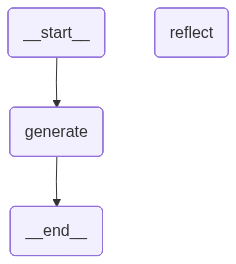

In [13]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
drafts = []
for event in graph.stream({"messages": [("user", request)]}):
    for node_name, output in event.items():
        print(f'At Node: {node_name}. Output: {output["messages"][-1].content}')
        if node_name == 'generate':
            drafts.append(output["messages"][-1])
        print('----')

At Node: generate. Output: 🎬 Exciting News! 🚀 

Today marks a significant milestone—I've completed DAY ONE of filming my AI Agent course! 🌟 

It's been a journey filled with curiosity and creativity as I dive deep into the transformative world of artificial intelligence. 🎓✨ From exploring foundational concepts to crafting engaging content, I’m thrilled to share insights that can empower others to embrace AI.

A big shoutout to my amazing team for their support and encouragement! 🙌🎥 Your collaboration fuels this project, and I can’t wait to see where the next filming days take us.

Stay tuned for updates! Together, let’s unlock the potential of AI and take our skills to the next level! 💡💻

#AIAgent #Filming #Education #LifelongLearning #Innovation #AI #TechTrends
----
At Node: reflect. Output: **Critique of the Post:**

1. **Length**: The post is fairly lengthy but remains engaging. However, some readers may feel overwhelmed with the amount of information presented in one go. A more con

In [127]:
for i, draft in enumerate(drafts):
    print(f'Draft {i}')
    print('-----------------------------------------------------------')
    print(draft.content)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

Draft 0
-----------------------------------------------------------
🎬 Exciting Milestone Alert! 🚀

Today marked Day One of filming my AI Agent course, and I couldn't be more thrilled! 🎉✨

After months of planning, brainstorming, and structuring the content, it's incredible to see it all come to life. I’ve poured my passion for artificial intelligence into this course, and I’m eager to share insights that can empower others to harness the potential of AI agents in their own projects.

Filming was a blend of exhilarating and nerve-wracking moments, but each take brought me closer to my vision. I can't wait to see how this journey unfolds and to share it with all of you!

A special shoutout to my amazing crew for their support and expertise! 🙌 

Stay tuned for more updates as we continue this adventure. Let’s embrace the future of AI together! 💡🤖

#AI #Filming #CourseCreation #LearningJourney #Innovation #ArtificialIntelligence
-----------------------------------------------------------
-

In [15]:
# Listen for state updates
for event in graph.stream({"messages": [("user", request)]}, stream_mode=["messages", "values"]):
    if event[0] == 'values': 
        print(event[1].keys(), len(event[1]['messages']))
        print(event[1]['messages'][-1].content)

dict_keys(['messages']) 1
Write one about me completing day one of filming my AI agent course
dict_keys(['messages']) 2
🎬 Exciting Day One in the Books! 🎉

Today marks a significant milestone as I completed the first day of filming my AI agent course! 🚀 From concept to camera, it’s been a whirlwind of creativity, preparation, and passion. 

The journey has just begun, but I can already feel the energy of sharing knowledge and insights with all of you. The world of AI is evolving at lightning speed, and I’m thrilled to contribute to this conversation by distilling complex concepts into actionable lessons. 📚✨

Huge shoutout to my incredible team for their support and collaboration. 🙌 Your hard work makes all the difference! 

Can’t wait to share more updates as we continue this journey. 💡 Stay tuned for what's coming next!

#AIAgents #Filming #Education #Innovation #LearningJourney 
dict_keys(['messages']) 3
### Critique and Recommendations:

Your post is engaging and enthusiastic, which